# Clustering Analysis on the AI-ready PHIPS Image Classification Dataset

##### This notebook peforms a clustering analysis on the images in the "PHIPS_CrystalHabitAI_Dataset.nc" AI-ready dataset with the aim of gaining insights into the inherent structure and possible groupings within the data.

In [1]:
# Import basic packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Define the file path of the dataset
file_path = '/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

# Display the dataset
ds

<xarray.Dataset>
Dimensions:      (samples: 440, height: 1024, width: 1360)
Coordinates:
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 433 434 435 436 437 438 439
Dimensions without coordinates: height, width
Data variables:
    image_array  (samples, height, width) uint8 ...
    timestamp    (samples) <U19 ...
    label        (samples) <U14 ...
    latitude     (samples) float64 ...
    longitude    (samples) float64 ...
    temperature  (samples) float64 ...
    altitude     (samples) float64 ...
Attributes:
    description:    AI-ready dataset for ice crystal habit classification in ...
    creation_date:  2024-10-24
    author:         Valeria Garcia (vgarcia1@uw.edu)

## 1. Data pre-processing 

In [3]:
# Flatten the image arrays (convert each image from a 2D array to a 1D vector)
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Scales features in data using statistics that are robust to outliers.
# Before applying PCA (a dimensionality reduction method), it's important to scale the data so that each feature contributes equally to the analysis.

from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(image_arrays)

## 2. Apply Principle Component Analysis (PCA) for dimensionality reduction

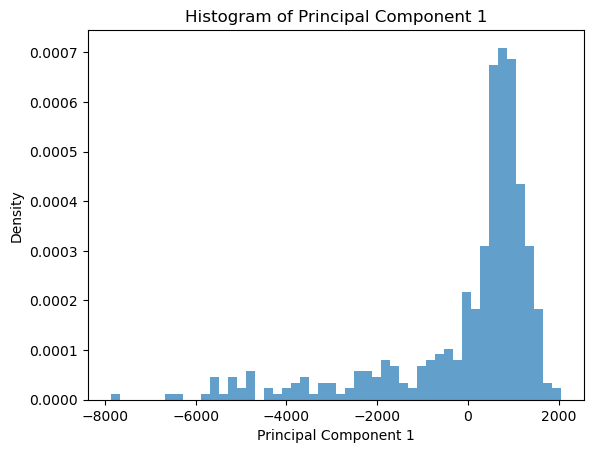

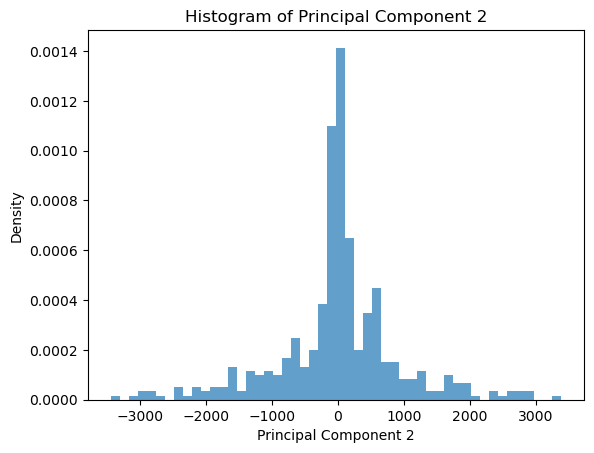

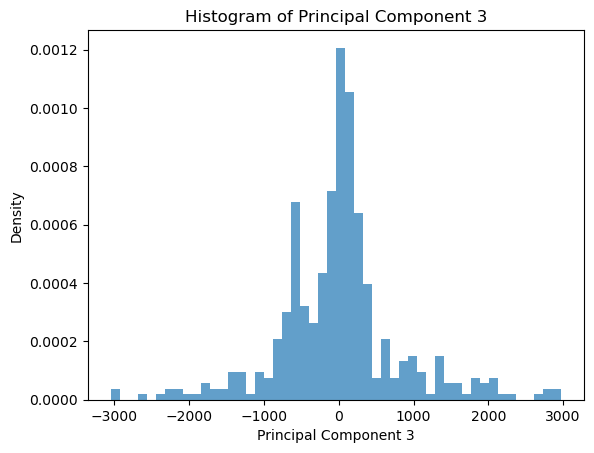

In [4]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Plot histograms of the first few principal components to check how the data is distributed
num_components = 3 
for i in range(num_components):
    plt.hist(pca_result[:, i], bins=50, density=True, alpha=0.7)
    plt.title(f'Histogram of Principal Component {i+1}')
    plt.xlabel(f'Principal Component {i+1}')
    plt.ylabel('Density')
    plt.show()

* First Principal Component (PC1): Negatively skewed with a long tail to the left.
* Second Principal Component (PC2): More symmetrical distribution.
* Third Principal Component (PC3): Slightly less symmetrical with a main peak and a smaller secondary peak to the left (possible bimodality).

### Interpretation:
##### The skewness and potential bimodality in the principal components suggests that the data does not follow a perfect Gaussian (normal) distribution. 

* Negative Skew in PC1: Indicates a long tail of lower values, suggesting that a subset of the data has significantly lower scores along this component.
* Bimodality in PC3: The presence of two peaks implies that there may be two subgroups within the data along this component.

##### Given these observations, K-means clustering is likely not the most suitable algorithm to use for the clustering analysis due to its assumption that the data distribution is roughly Gaussian. Instead of K-means, we will use Gaussian Mixture Models (GMMs) clustering for the clustering analysis. GMMs are well-suited for data with skewness and potential bimodality. 

### Advanatages of GMMS:

* They can model clusters with different shapes, sizes, and orientations.
* Handles skewed and multimodal distributions better than K-means.
* Each cluster is modeled as a Gaussian distribution, allowing for elliptical shapes.

## 2. Implement Gaussian Mixture Models (GMMs) clustering on the PCA-transformed data

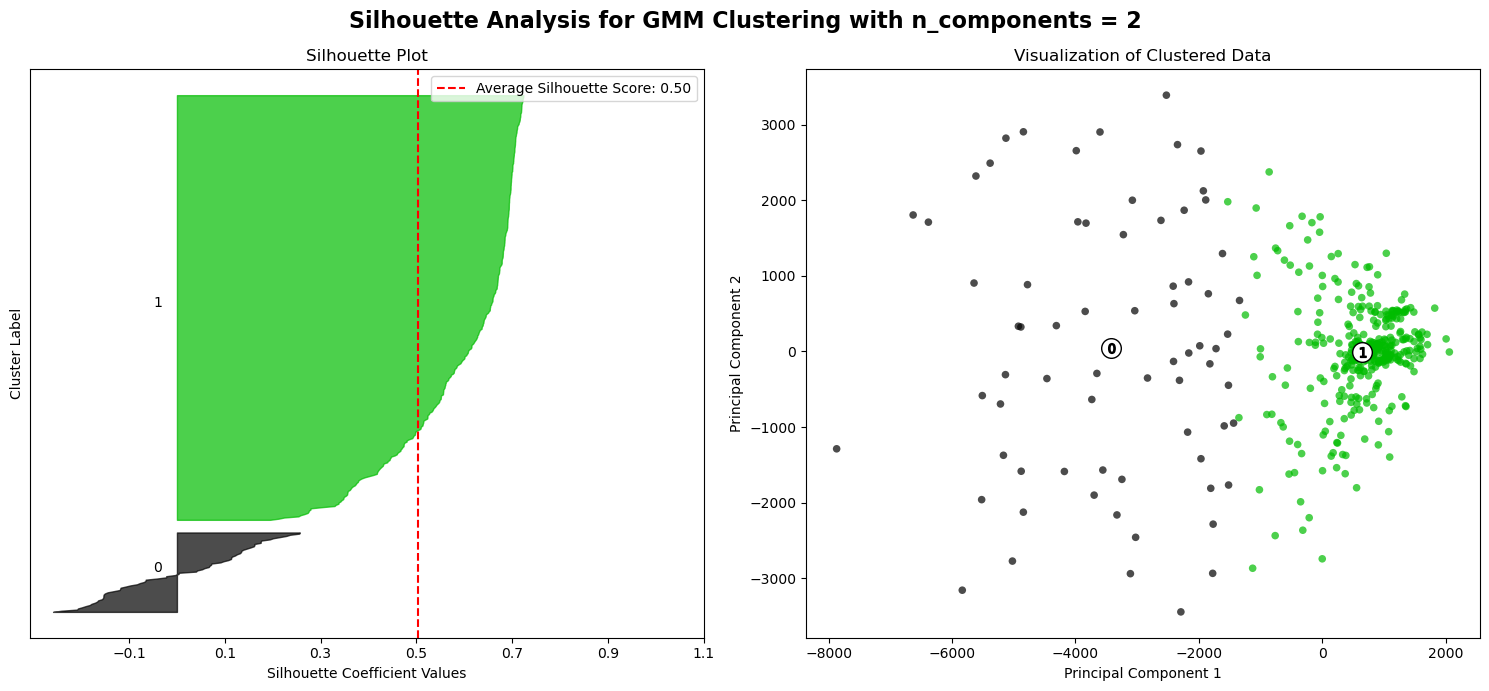

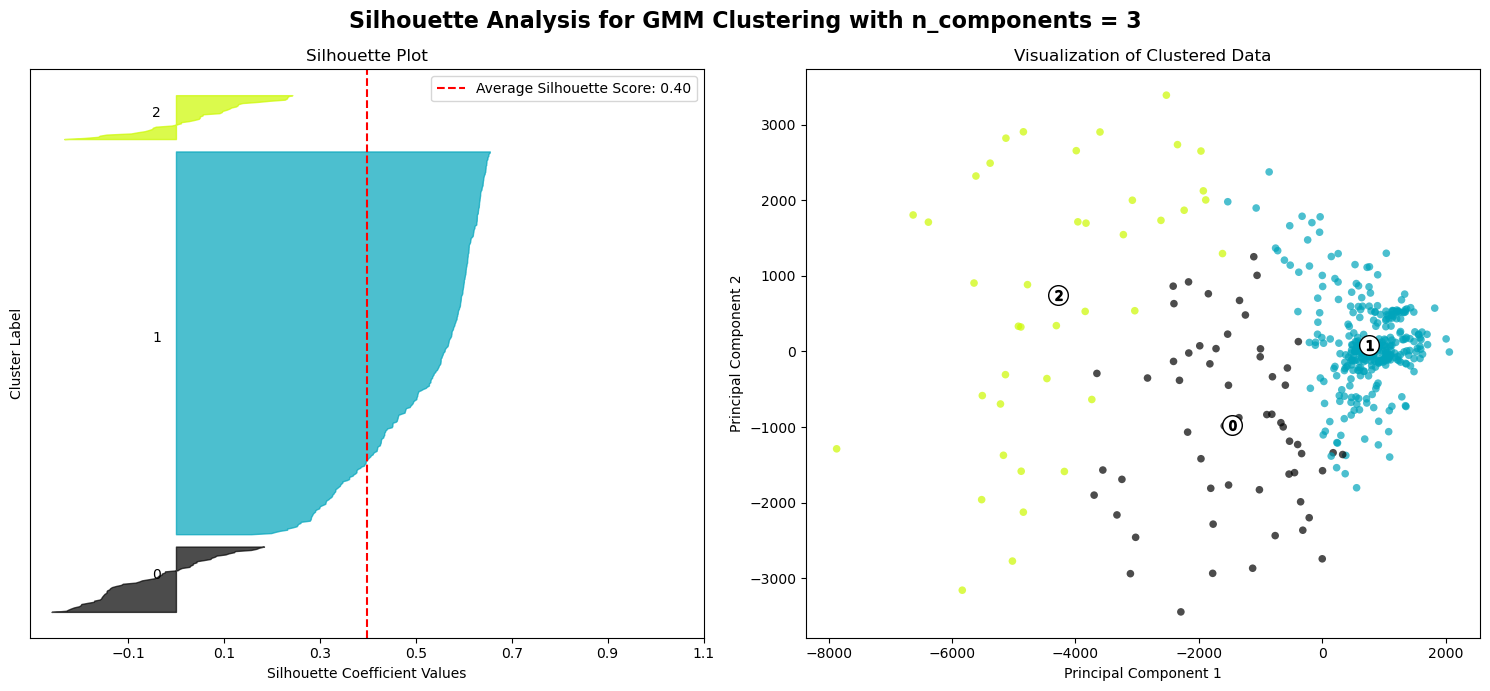

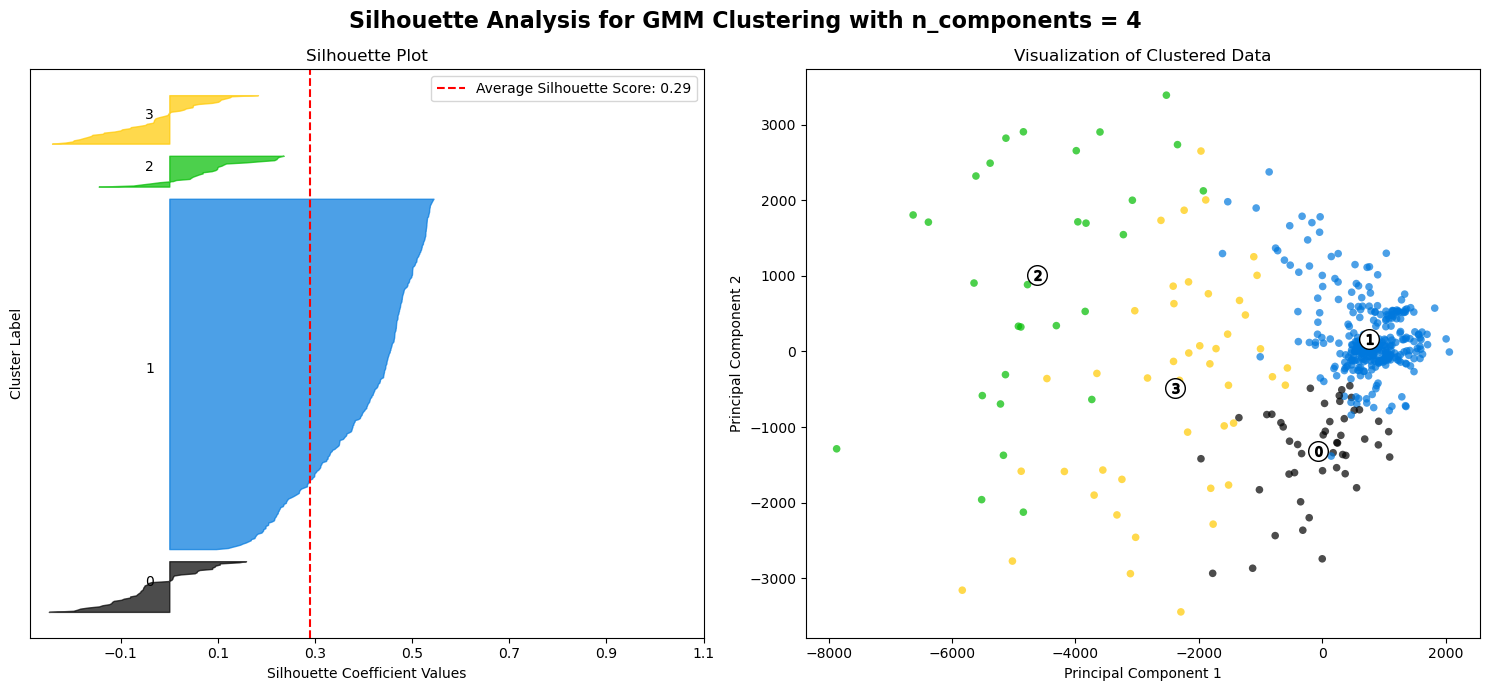

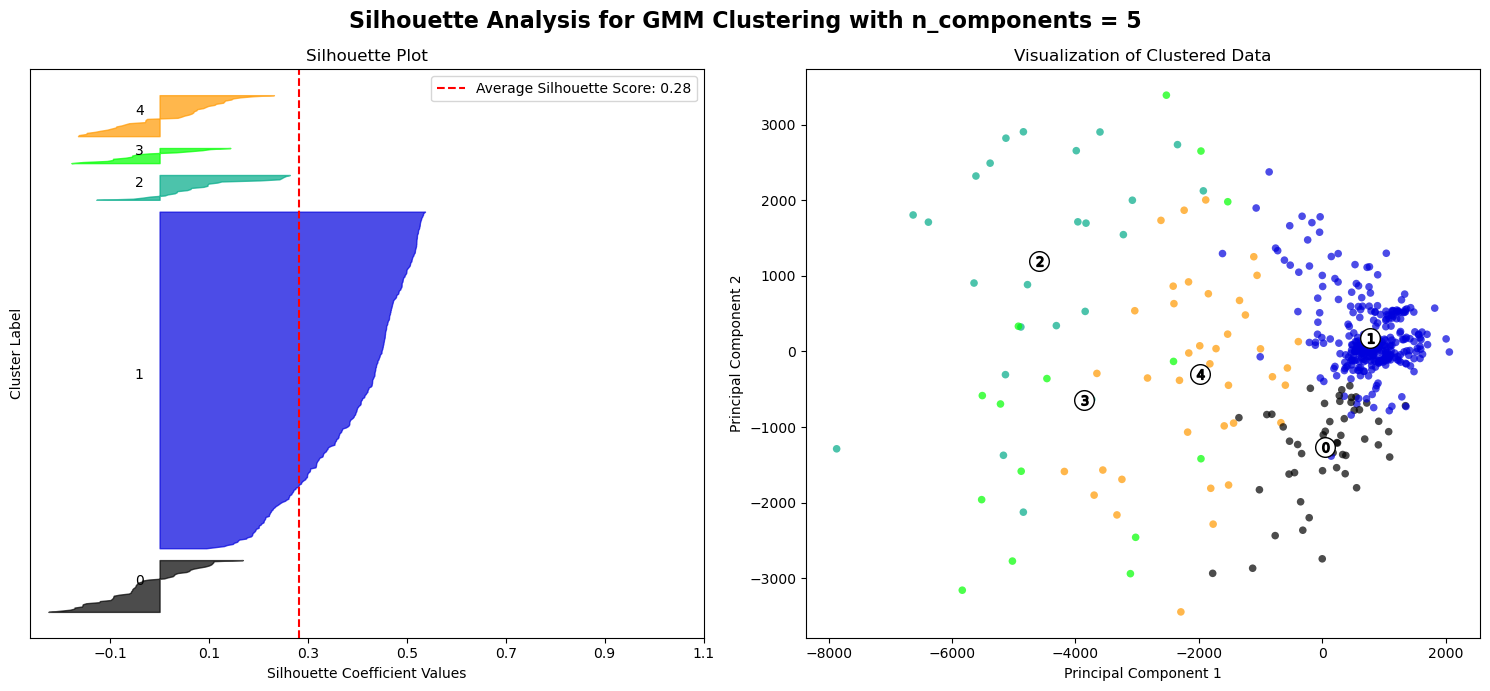

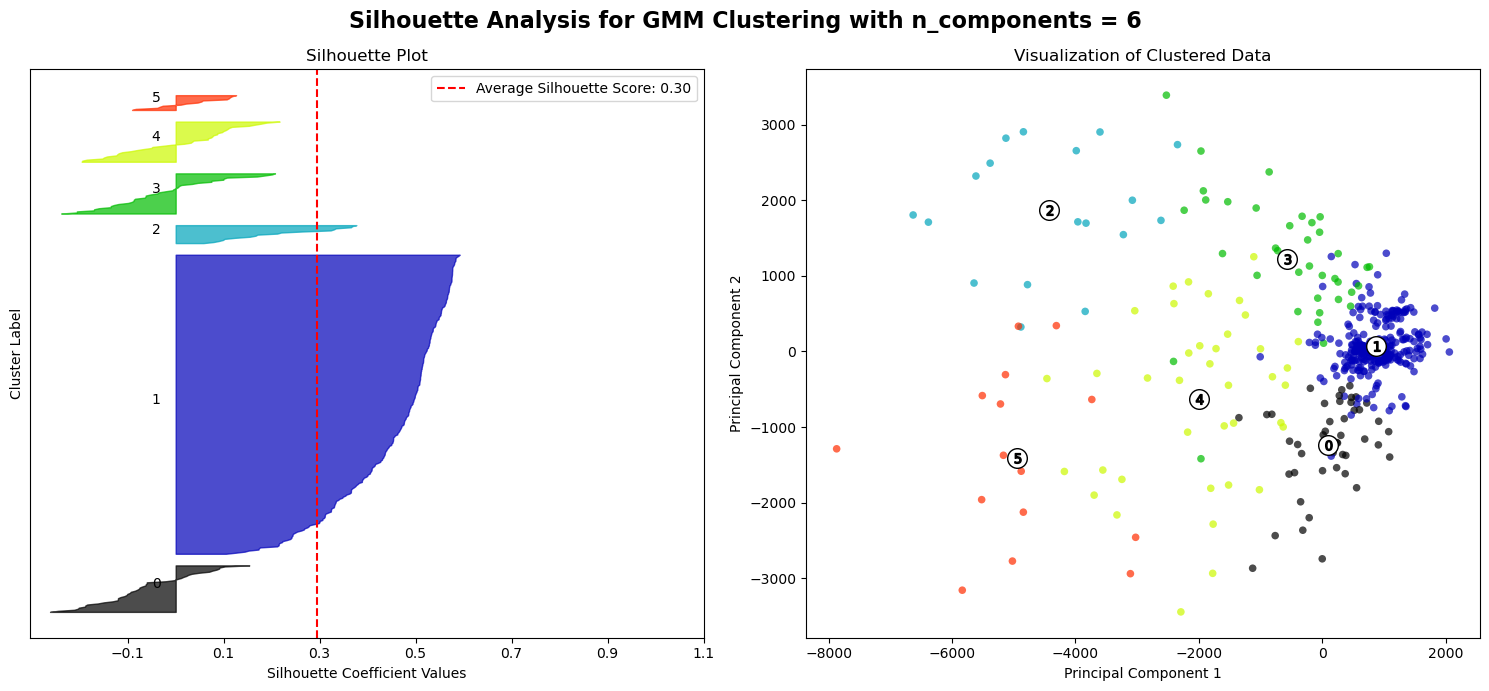

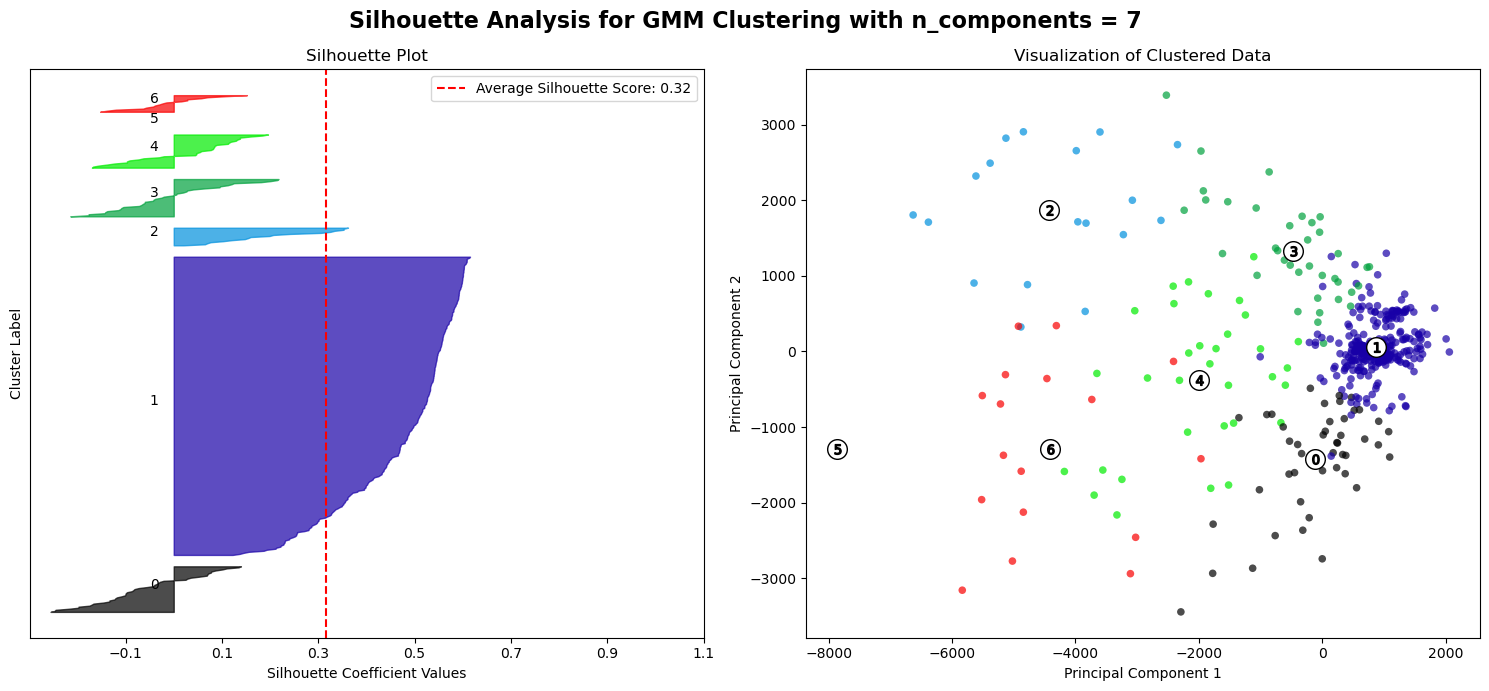

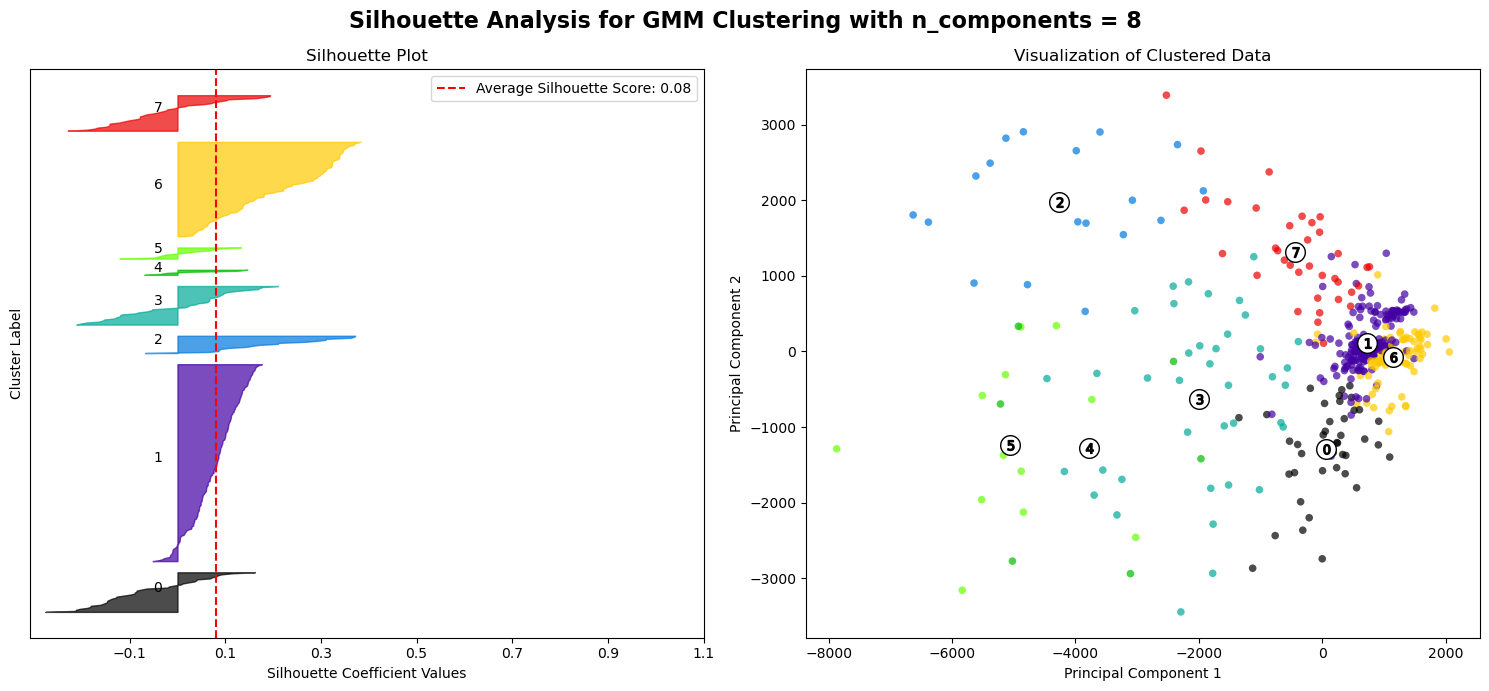

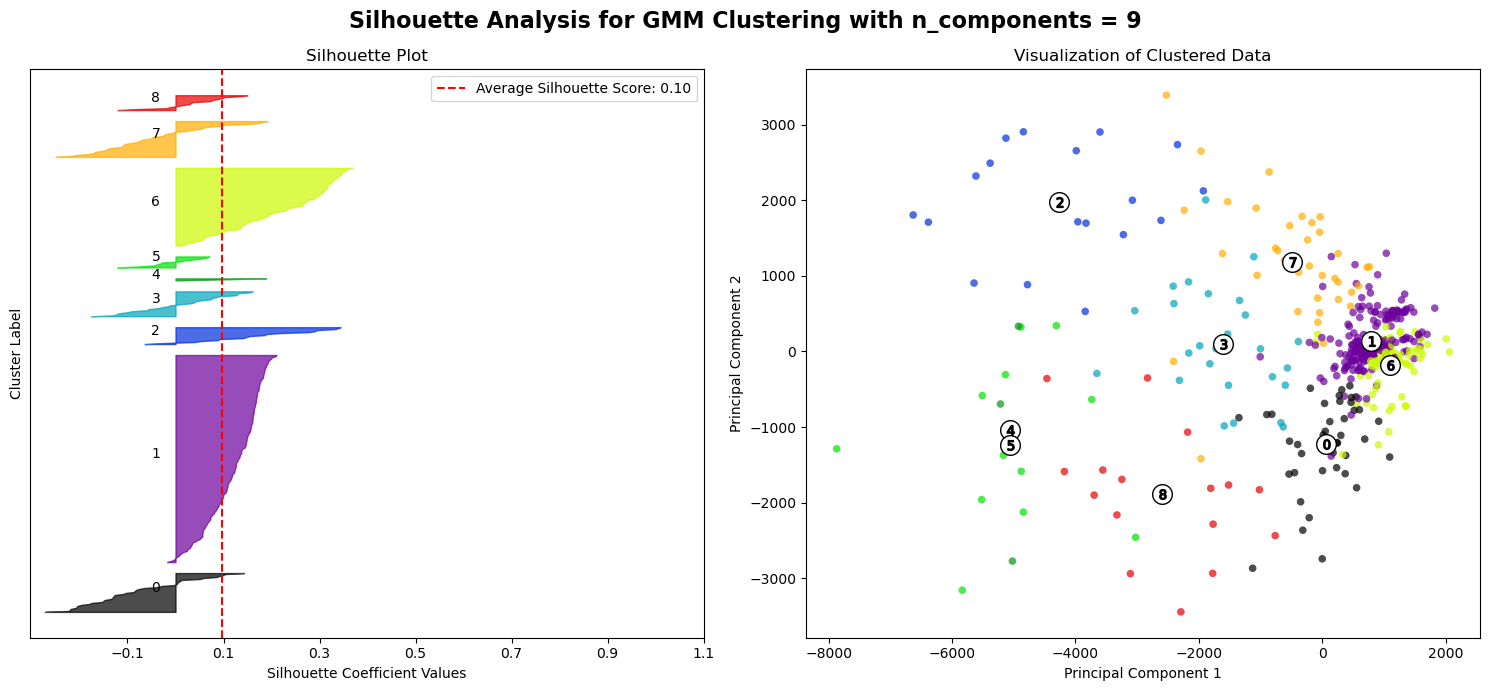

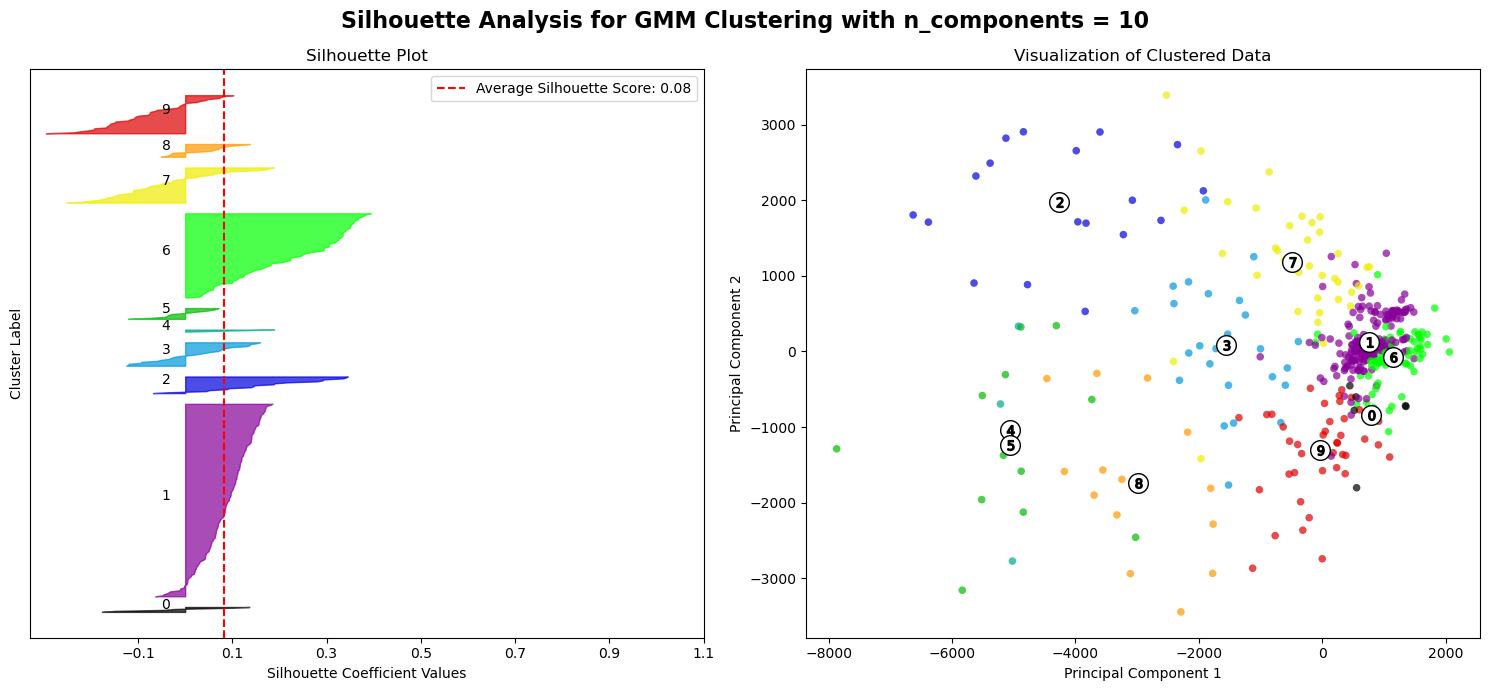

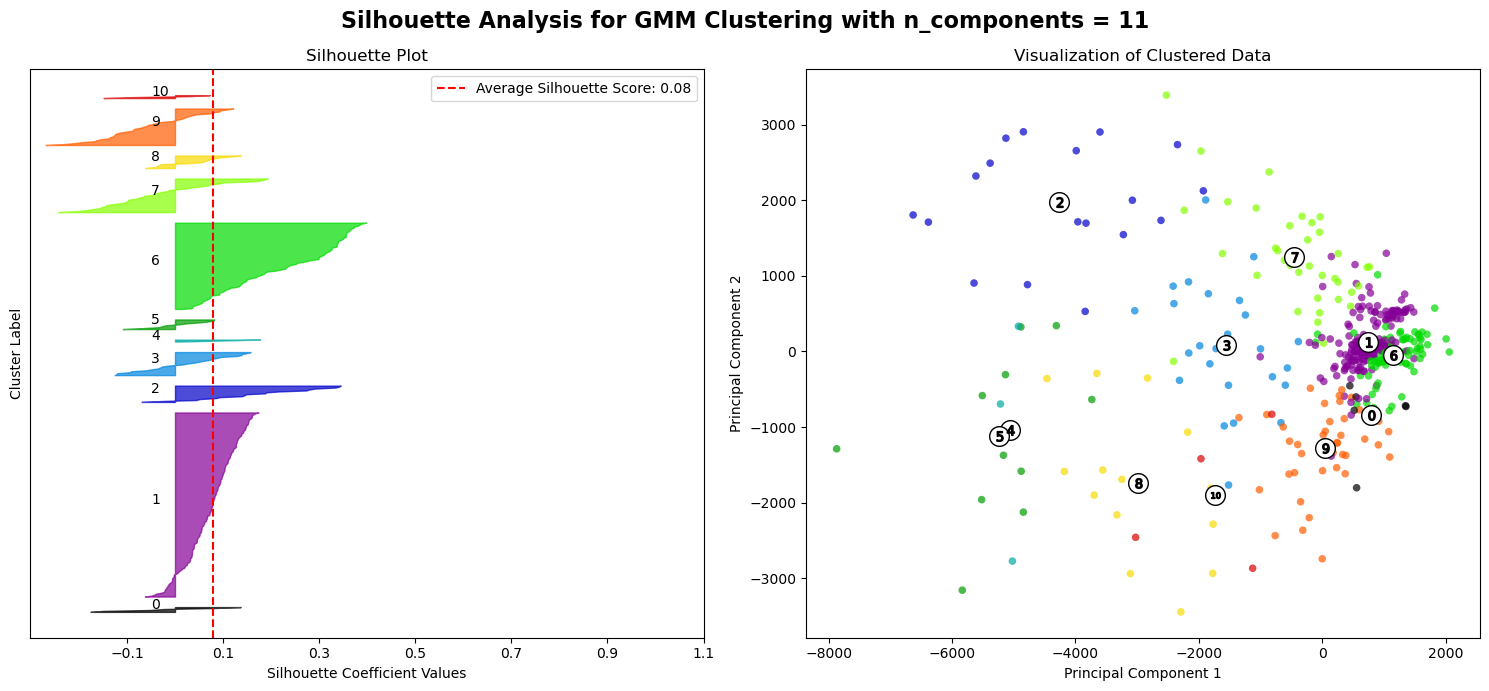

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from matplotlib import cm

# Define the range of components to test
# When using GMMs for clustering, each Gaussian component is interpreted as a cluster.

n_components_range = range(2, 21) # Starting from 2 since silhouette score isn't defined for 1 cluster

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2).fit_transform(pca_result)

# Lists to store BIC, AIC, and Silhouette scores
bic_scores = []
aic_scores = []
silhouette_scores = []

# Dictionary to store clustering results for selected numbers of components
cluster_results = {}

# List of components for which we want to plot clustering results
plot_n_components = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Adjust as needed

for n_components in n_components_range:
    # Fit a GMM with the current number of components
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(pca_result)
    
    # Predict cluster labels
    cluster_labels = gmm.predict(pca_result)
    
    # Compute BIC and AIC
    bic = gmm.bic(pca_result)
    aic = gmm.aic(pca_result)
    bic_scores.append(bic)
    aic_scores.append(aic)
    
    # Compute Silhouette Score if n_components > 1
    if n_components > 1:
        silhouette_avg = silhouette_score(pca_result, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)  # Cannot compute silhouette score for one cluster
    
    # Store cluster labels for selected n_components for plotting
    if n_components in plot_n_components:
        cluster_results[n_components] = cluster_labels
        #### Silhouette Plot and Cluster Visualization ####

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        fig.suptitle(f"Silhouette Analysis for GMM Clustering with n_components = {n_components}", fontsize=16, fontweight='bold')

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pca_result, cluster_labels)

        y_lower = 10
        ax1.set_title("Silhouette Plot")
        ax1.set_xlabel("Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")

        # Aggregate silhouette scores for samples in each cluster, sort them, and plot
        for i in range(n_components):
            # Aggregate the silhouette scores for samples belonging to cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            # Sort the silhouette values
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_components)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average Silhouette Score: {silhouette_avg:.2f}")
        ax1.set_yticks([])  # Clear the y-axis labels / ticks
        ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
        ax1.legend()

        # Second Plot: Clustered Data Visualization
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_components)
        ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("Visualization of Clustered Data")
        ax2.set_xlabel("Principal Component 1")
        ax2.set_ylabel("Principal Component 2")

        # Labeling the clusters
        centers = gmm.means_[:, :2]  # Use the first two dimensions for visualization
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        plt.tight_layout()
        plt.show()


# #### Visualize clustering results ####

# from matplotlib.colors import ListedColormap, BoundaryNorm

# # Reduce data to 2D for visualization
# pca_2d = PCA(n_components=2).fit_transform(pca_result)

# # Determine the number of subplots based on the number of selected components
# num_plots = len(plot_n_components)
# cols = 2  # Number of columns in the subplot grid
# rows = (num_plots + cols - 1) // cols  # Calculate rows needed

# fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
# axes = axes.flatten()

# for idx, n_components in enumerate(plot_n_components):
#     cluster_labels = cluster_results[n_components]
#     ax = axes[idx]
    
#     # Create a discrete colormap with n_components colors
#     cmap = plt.cm.get_cmap('tab20', n_components)
    
#     # Create a normalization object to map cluster labels to colors
#     norm = BoundaryNorm(np.arange(-0.5, n_components + 0.5, 1), n_components)
    
#     # Plot the scatter plot with the custom colormap and normalization
#     scatter = ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=cluster_labels, cmap=cmap, norm=norm, s=15, alpha=0.7)
#     ax.set_title(f'GMM Clustering with {n_components} Components')
#     ax.set_xlabel('Principal Component 1')
#     ax.set_ylabel('Principal Component 2')
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     # Add a color bar with correct labels
#     cbar = fig.colorbar(scatter, ax=ax, ticks=np.arange(n_components))
#     cbar.set_label('Cluster Label')
#     cbar.set_ticks(np.arange(n_components))
#     cbar.set_ticklabels(np.arange(n_components))
    
# # Hide any unused subplots
# for i in range(len(plot_n_components), len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

## 3. Evaluate GMM clustering performance

##### Metrics computed:
* Silhouette score (see silhouette plot above)
    * Ranges from -1 to 1.
    * Values near 1: Sample is far from neighboring clusters (good).
    * Values near 0: Sample is on or very close to the decision boundary between two clusters.
    * Values near -1: Samples might have been assigned to the wrong cluster.
    * The thickness of each cluster's silhouette plot corresponds to the number of samples in that cluster.
    * Average silhouette score represented by the vertical dashed line, giving an an overall assessment of how well the clusters are defined.


-- INSERT HERE DISCUSSION ABOUT PEFORMANCE OF SILOUETTE COEFFICIENT AND WHY IT IS BAD ACROSS ALL CLUSTERS WITH NEGATIVE VALUES, UNEVEN CLUSTER WIDTHS SHOWING UNEVEN NUMBER OF DATA POINTS PER CLUSTER, ETC. --


* BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion), along with the elbow point: 
    * Both are statistical measures used to evaluate and compare models by balancing model fit and complexity. 
    * BIC interpretation: lower BIC values indicate a better balance between model fit and complexity.
    * AIC interpretation; similar to BIC but with a different penalty for the number of parameters.



-- INSERT HERE DISCUSSION ABOUT BIC and AIC VALUES SHOWING ELBOW POINTS THAT DISAGREE WITH EACH OTHER, INCONSISTENT --


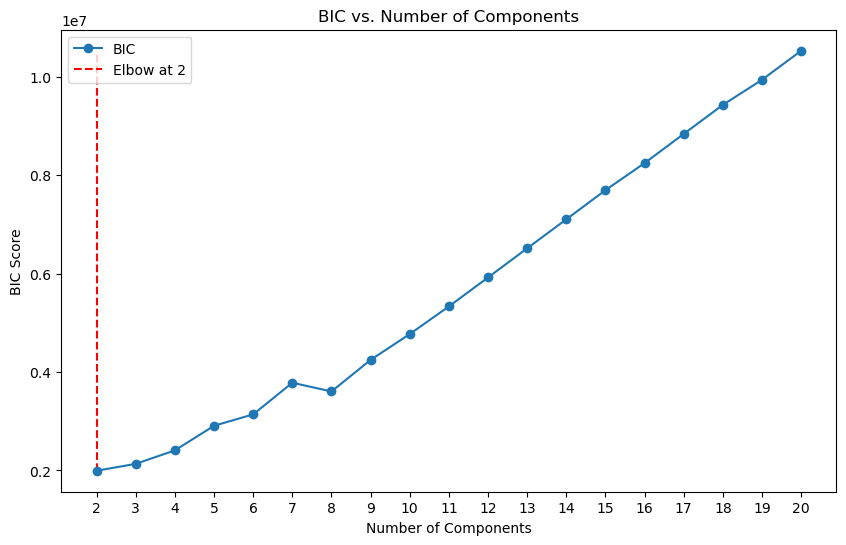

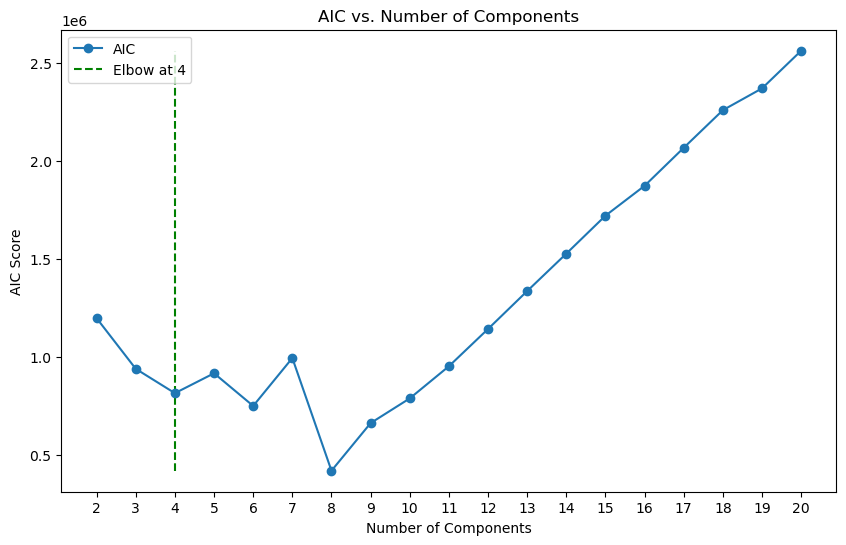

Optimal number of components according to BIC elbow: 2
Optimal number of components according to AIC elbow: 4


In [8]:
from kneed import KneeLocator

# Convert scores to NumPy arrays for consistency
bic_scores = np.array(bic_scores)
aic_scores = np.array(aic_scores)

# Use KneeLocator to find the elbow point in the BIC scores
bic_kneedle = KneeLocator(n_components_range, bic_scores, curve='convex', direction='decreasing')
bic_elbow = bic_kneedle.elbow

# Use KneeLocator to find the elbow point in the AIC scores
aic_kneedle = KneeLocator(n_components_range, aic_scores, curve='convex', direction='decreasing')
aic_elbow = aic_kneedle.elbow

# Plot BIC scores and mark the elbow point
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.vlines(bic_elbow, bic_scores.min(), bic_scores.max(), linestyles='dashed', colors='red', label=f'Elbow at {bic_elbow}')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC vs. Number of Components')
plt.xticks(n_components_range)
plt.legend()
plt.show()

# Plot AIC scores and mark the elbow point
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.vlines(aic_elbow, aic_scores.min(), aic_scores.max(), linestyles='dashed', colors='green', label=f'Elbow at {aic_elbow}')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC vs. Number of Components')
plt.xticks(n_components_range)
plt.legend()
plt.show()

# Print the optimal number of components according to the elbow method
print(f'Optimal number of components according to BIC elbow: {bic_elbow}')
print(f'Optimal number of components according to AIC elbow: {aic_elbow}')

## 4. Attempt K-Means clustering anyway

##### As the GMM clustering yielded poor results, we will attempt K-means clustering despite the initial concerns. K-means might handle the data better, especially if the data's clustering structure aligns more with K-means' assumptions than expected. 

For n_clusters = 2, the average silhouette_score is : 0.5037


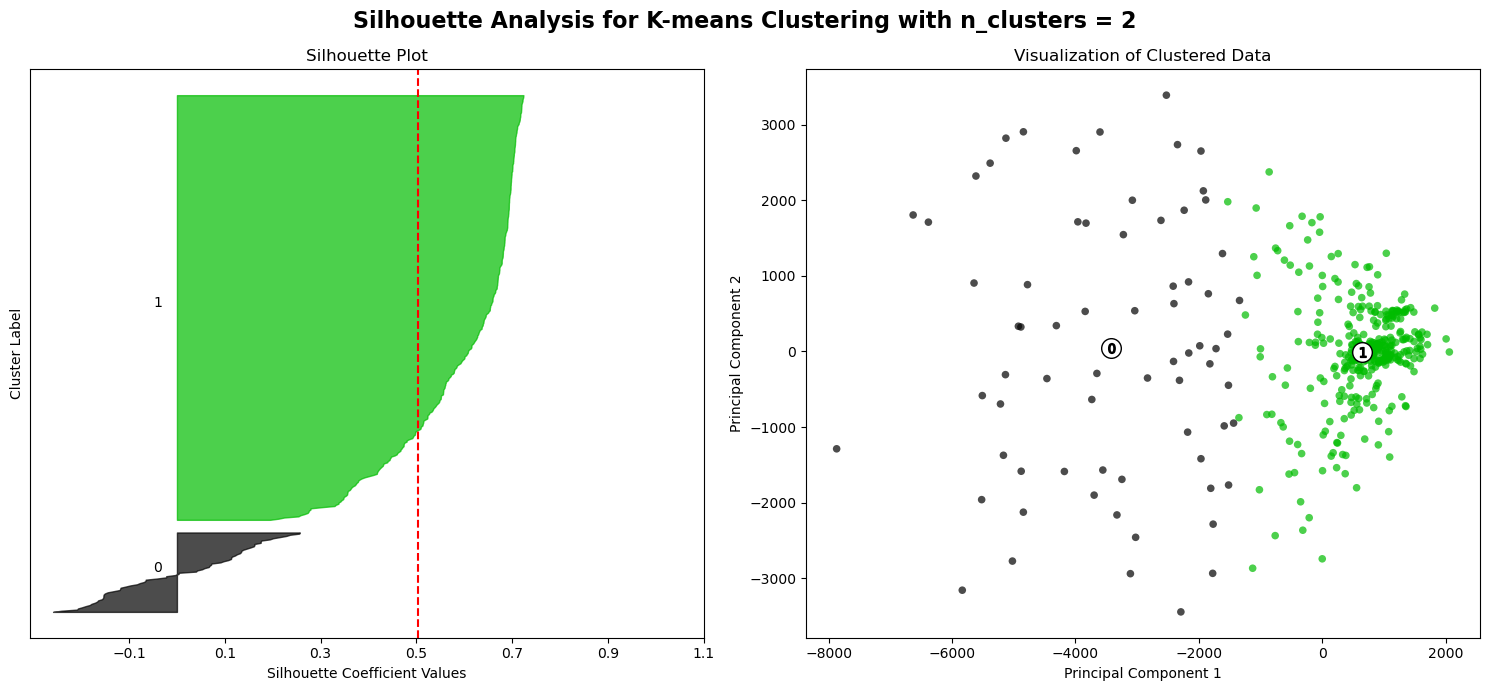

For n_clusters = 3, the average silhouette_score is : 0.3981


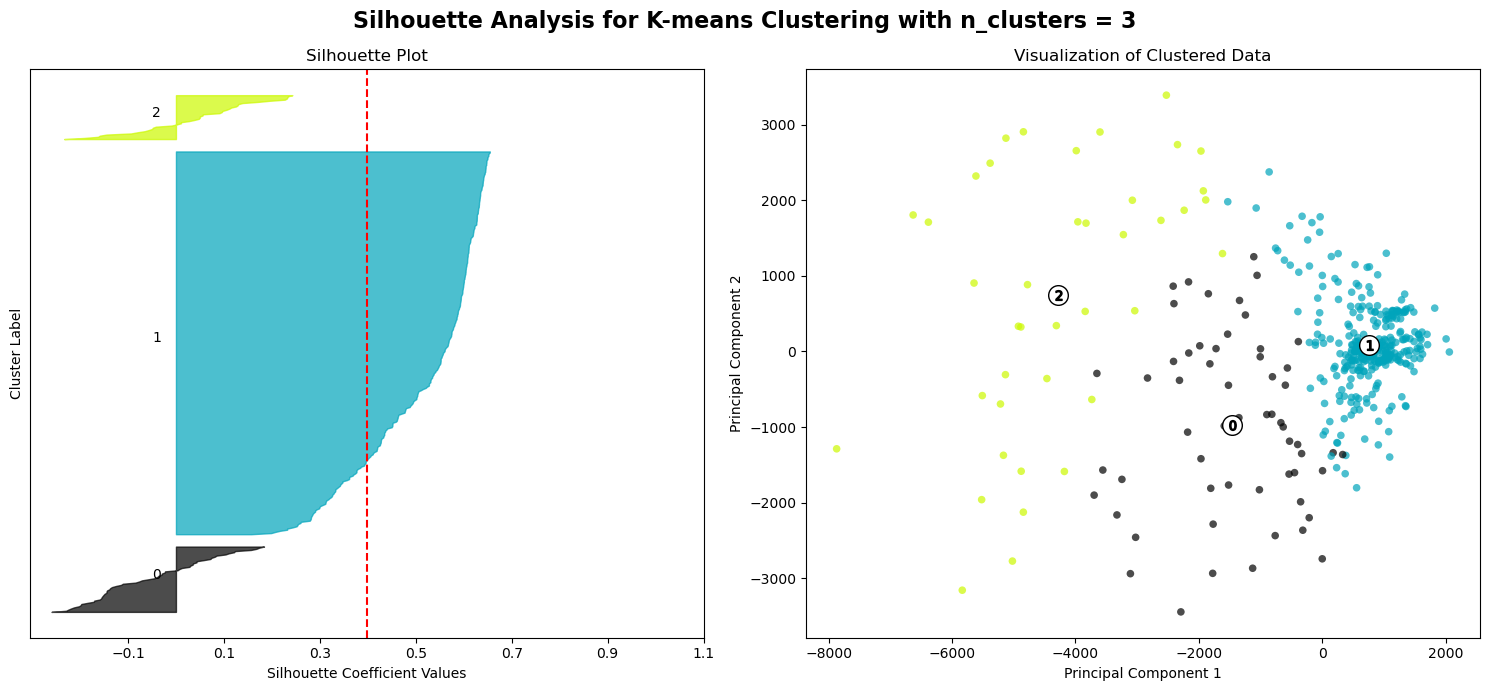

For n_clusters = 4, the average silhouette_score is : 0.2888


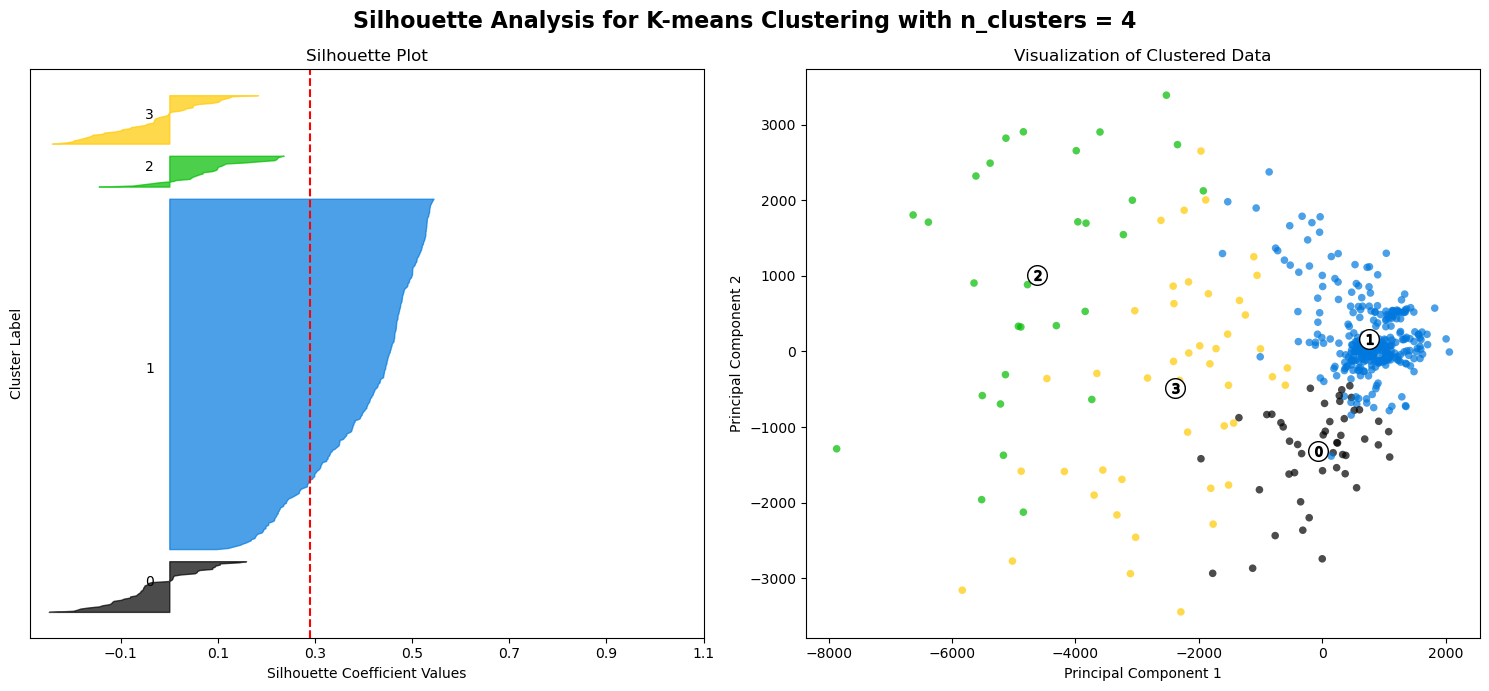

For n_clusters = 5, the average silhouette_score is : 0.2823


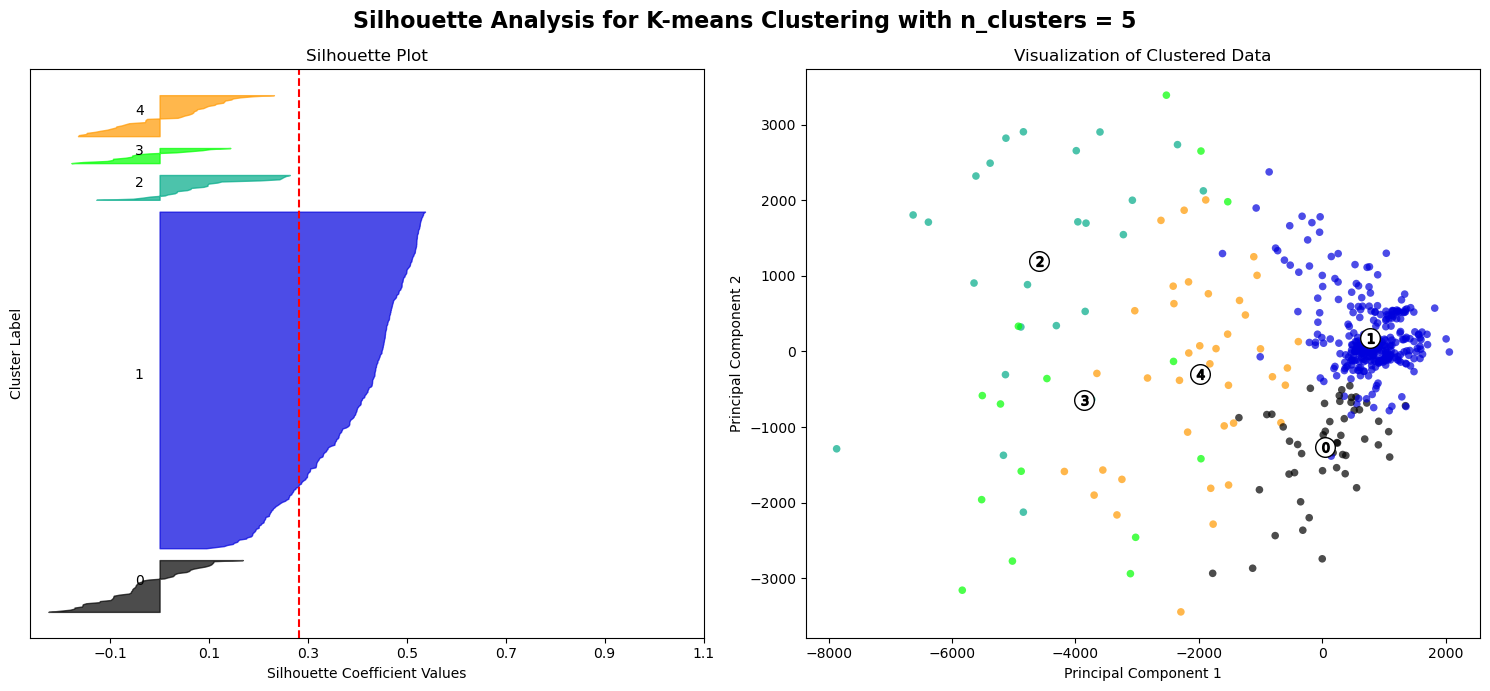

For n_clusters = 6, the average silhouette_score is : 0.2951


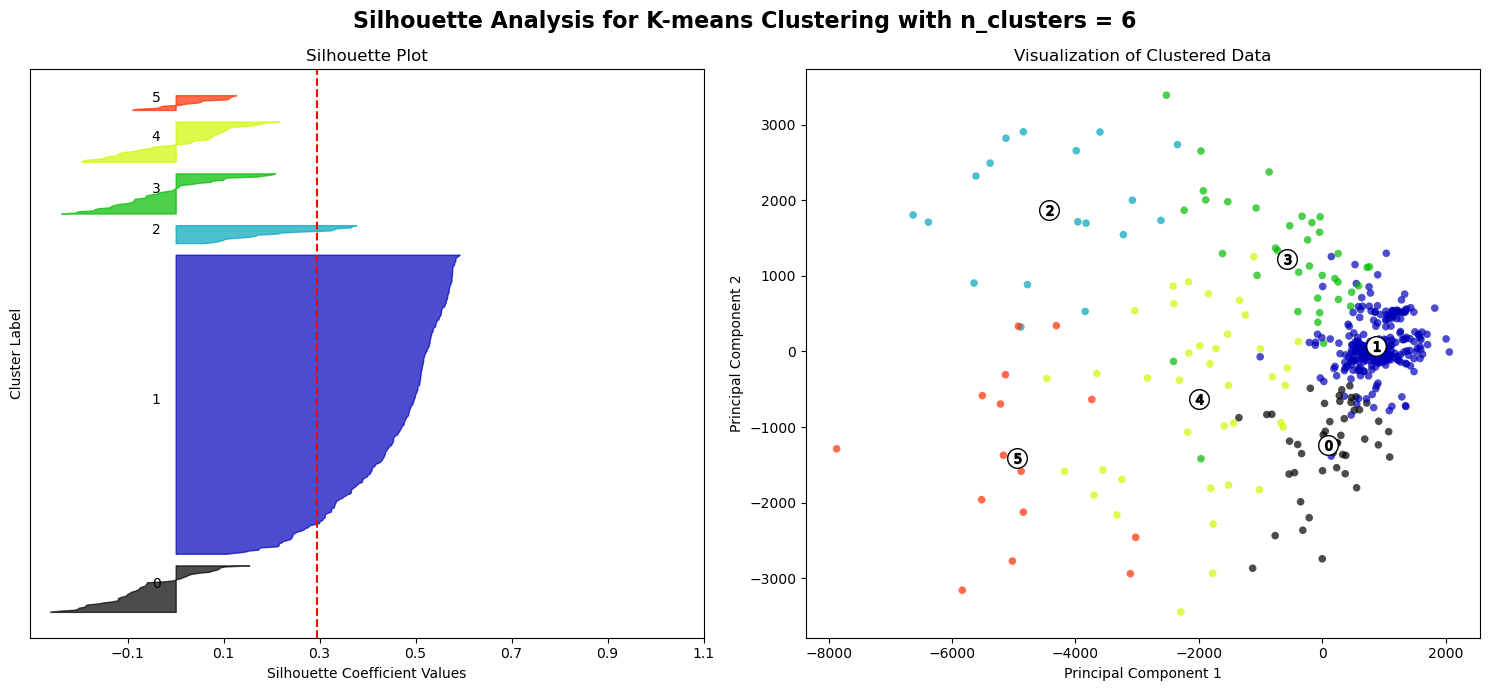

For n_clusters = 7, the average silhouette_score is : 0.3162


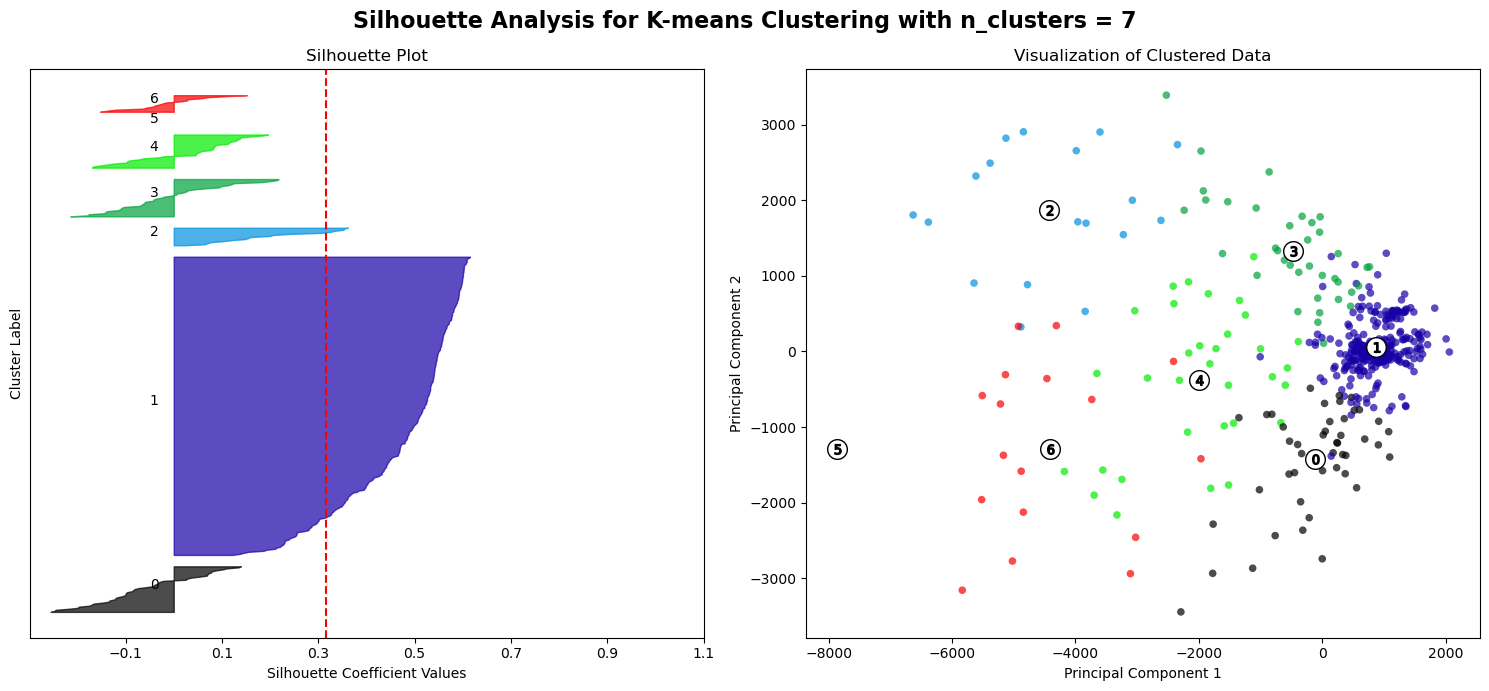

For n_clusters = 8, the average silhouette_score is : 0.0800


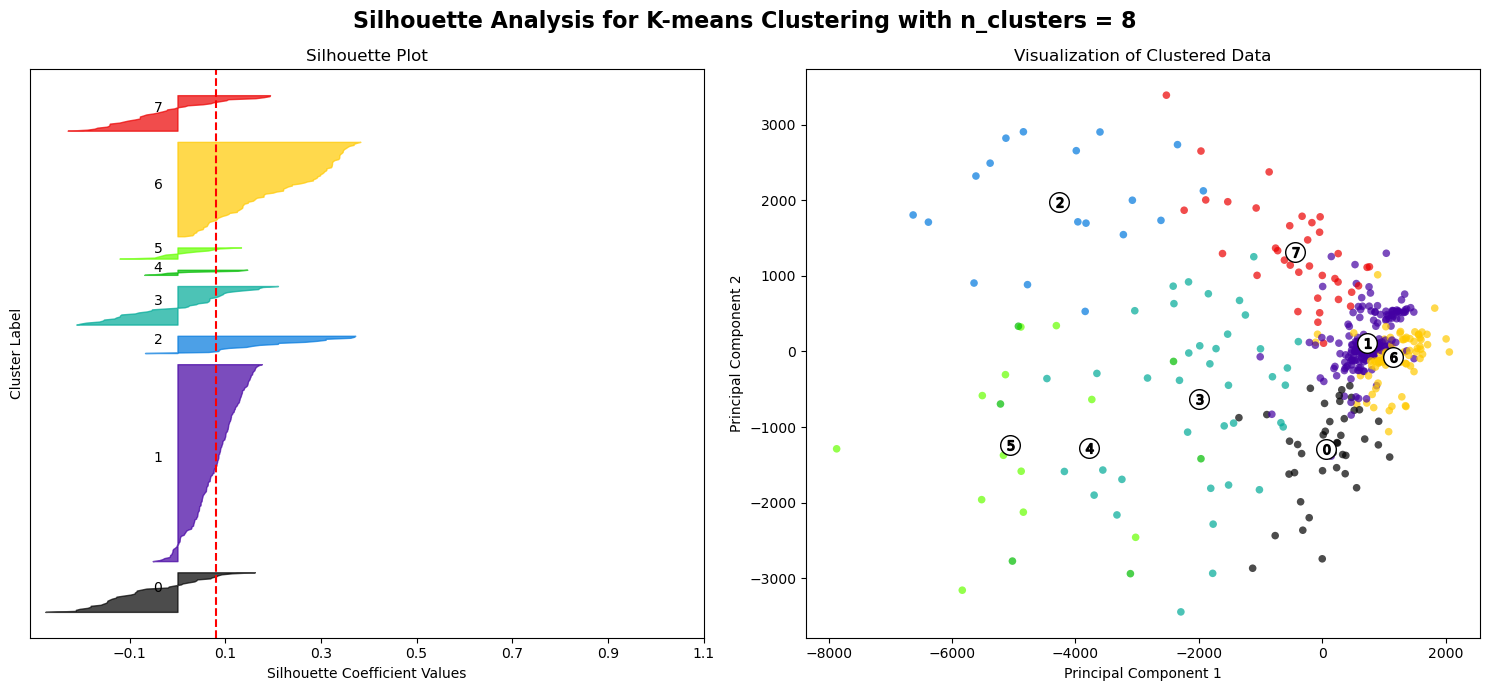

For n_clusters = 9, the average silhouette_score is : 0.0960


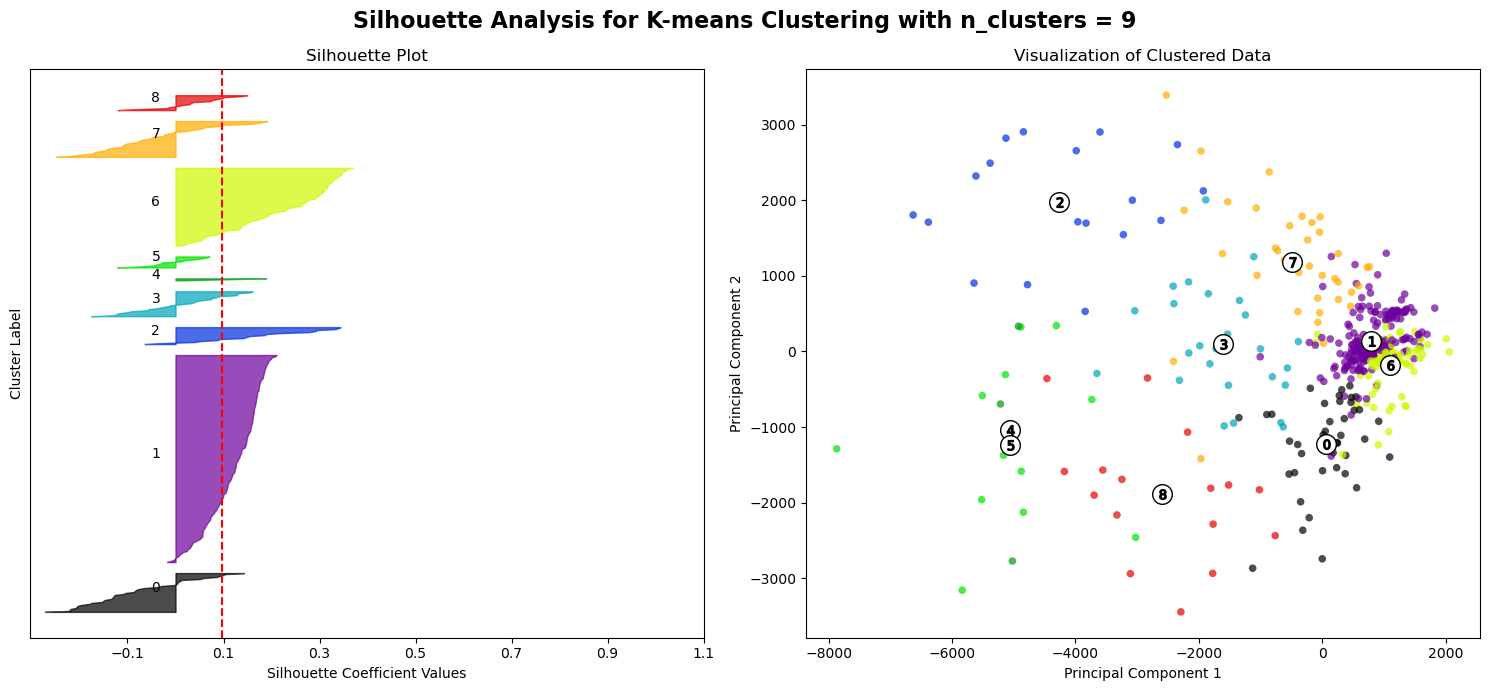

For n_clusters = 10, the average silhouette_score is : 0.0818


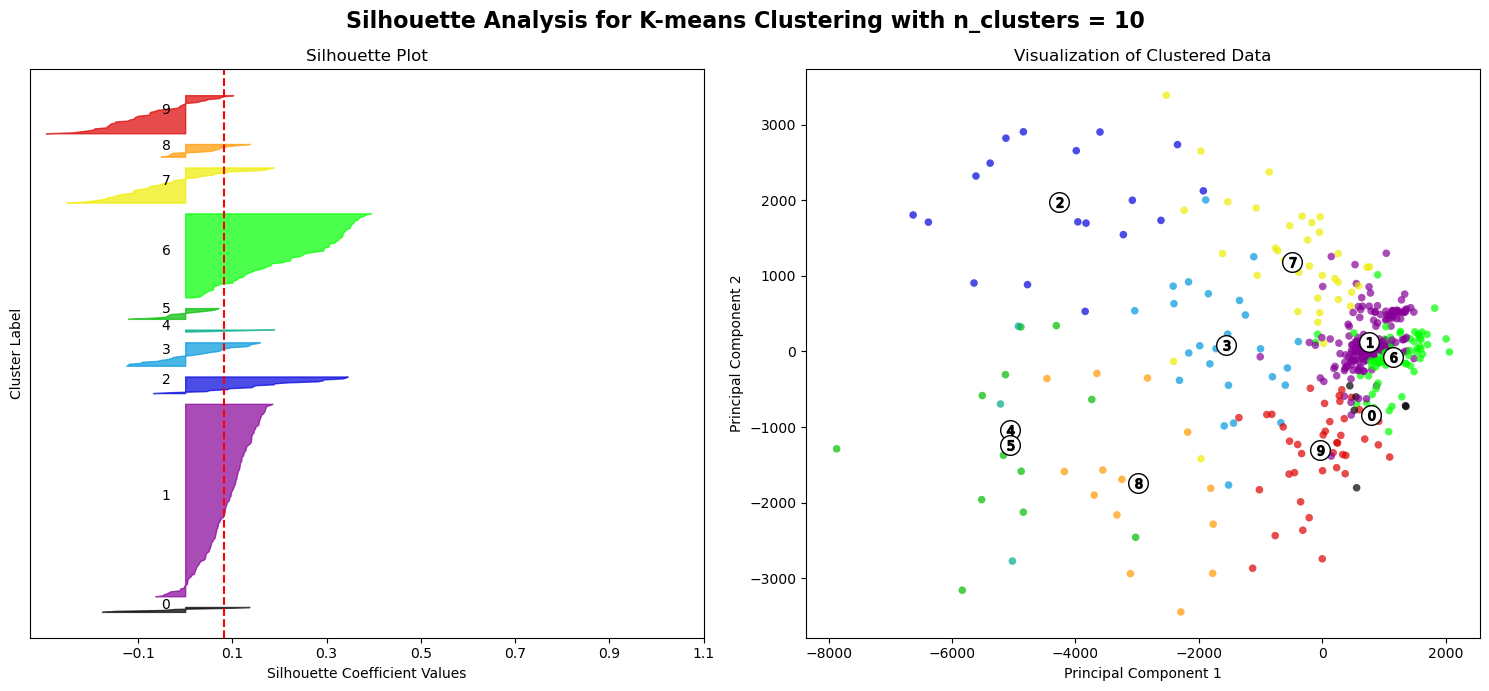

For n_clusters = 11, the average silhouette_score is : 0.0799


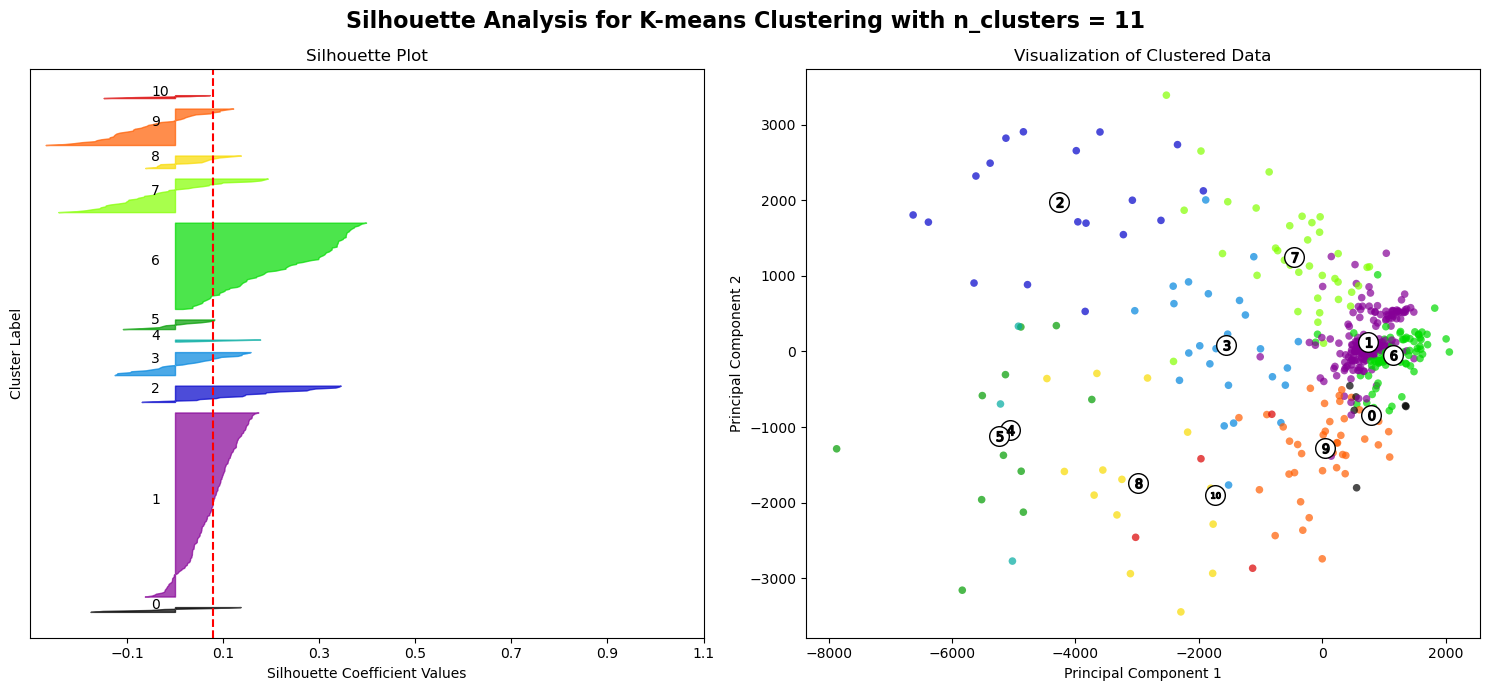

In [11]:
from sklearn.cluster import KMeans

# Define the range of clusters to test
n_clusters_range = range(2, 21)

# List of clusters for which we want to plot clustering results
plot_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Adjust as needed

# Assuming 'pca_2d' is your PCA-reduced data for visualization
for n_clusters in plot_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f"Silhouette Analysis for K-means Clustering with n_clusters = {n_clusters}", fontsize=16, fontweight='bold')
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
    
    silhouette_avg = silhouette_score(pca_result, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")
    sample_silhouette_values = silhouette_samples(pca_result, cluster_labels)
    
    y_lower = 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    ax2.set_title("Visualization of Clustered Data")
    ax2.set_xlabel("Principal Component 1")
    ax2.set_ylabel("Principal Component 2")
    
    centers = kmeans.cluster_centers_[:, :2]  # Use first two dimensions for visualization
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    
    plt.tight_layout()
    plt.show()

-- INSERT DISCUSSION ON SILHOUETTE PLOTS --

##### While the clustering performance is still poor, yielding some silhouette coefficient values below 0, a cluster count of 9 appears to yield an average silhouette score that is relatively higher than that of a cluster count of 8 and 10. A cluster count of 7 and fewer yield clusters with a disproportional number of data points sorted in each cluster, which is not preferable for selecting the optimal number of clusters.

## 5. Computing the Homogeneity Score, Fowlkes-Mallows Index, and Adjusted Rand Index (ARI) on the K-means clustering
* Homogeneity Score
    * Definition: Measures whether each cluster contains only members of a single class.
    * Range: 0.0 to 1.0
        * 1.0: Perfect homogeneity (each cluster contains only one class).
        * Closer to 1.0: Better clustering with respect to the ground truth labels.
* Fowlkes-Mallows Index
    * Definition: Assesses the similarity between the clusters and the ground truth labels.
    * Range: 0.0 to 1.0
        * 1.0: Perfect agreement between the clustering and true labels.
        * Higher Values: Better clustering performance.
* Adjusted Rand Index (ARI)
    * Definition: Measures the similarity between two clusterings, adjusted for chance grouping.
    * Range: -1.0 to 1.0
        * 1.0: Perfect agreement.
        * 0.0: Random labeling expected by chance.
        * Negative Values: Less agreement than expected by chance.


In [18]:
from sklearn.metrics import homogeneity_score, fowlkes_mallows_score, adjusted_rand_score

true_labels = ds.label  # Assign dataset's labels to true_labels

# Define the range of clusters to test
n_clusters_range = range(2, 21)

# Lists to store evaluation metrics
homogeneity_scores = []
fmi_scores = []
ari_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
    
    # Compute Homogeneity Score
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    homogeneity_scores.append(homogeneity)
    
    # Compute Fowlkes-Mallows Index
    fmi = fowlkes_mallows_score(true_labels, cluster_labels)
    fmi_scores.append(fmi)
    
    # Compute Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, cluster_labels)
    ari_scores.append(ari)
    
    print(f"For n_clusters = {n_clusters}, Homogeneity Score: {homogeneity:.4f}, "
          f"Fowlkes-Mallows Index: {fmi:.4f}, Adjusted Rand Index: {ari:.4f}")

For n_clusters = 2, Homogeneity Score: 0.0914, Fowlkes-Mallows Index: 0.2972, Adjusted Rand Index: 0.0312
For n_clusters = 3, Homogeneity Score: 0.1023, Fowlkes-Mallows Index: 0.2778, Adjusted Rand Index: 0.0328
For n_clusters = 4, Homogeneity Score: 0.1149, Fowlkes-Mallows Index: 0.2626, Adjusted Rand Index: 0.0338
For n_clusters = 5, Homogeneity Score: 0.1262, Fowlkes-Mallows Index: 0.2567, Adjusted Rand Index: 0.0330
For n_clusters = 6, Homogeneity Score: 0.1664, Fowlkes-Mallows Index: 0.2620, Adjusted Rand Index: 0.0554
For n_clusters = 7, Homogeneity Score: 0.1636, Fowlkes-Mallows Index: 0.2634, Adjusted Rand Index: 0.0538
For n_clusters = 8, Homogeneity Score: 0.1972, Fowlkes-Mallows Index: 0.2237, Adjusted Rand Index: 0.0700
For n_clusters = 9, Homogeneity Score: 0.2051, Fowlkes-Mallows Index: 0.2271, Adjusted Rand Index: 0.0690
For n_clusters = 10, Homogeneity Score: 0.2101, Fowlkes-Mallows Index: 0.2213, Adjusted Rand Index: 0.0689
For n_clusters = 11, Homogeneity Score: 0.214

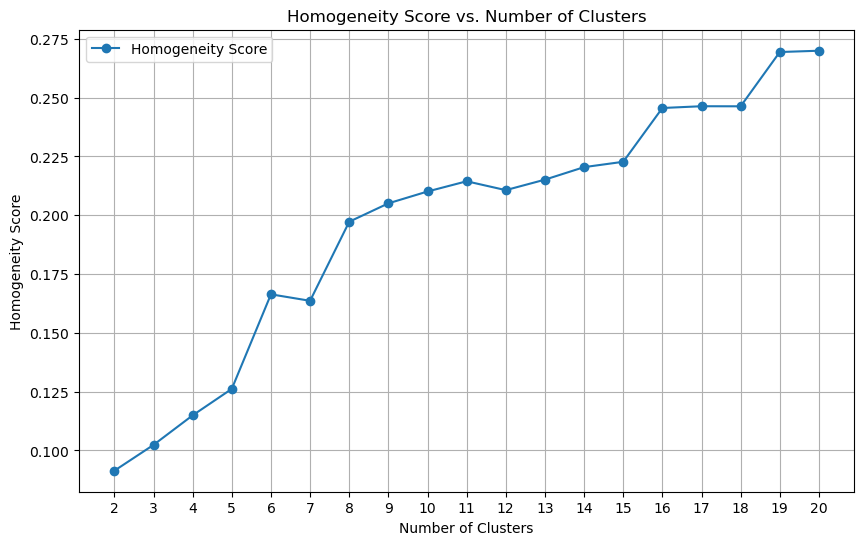

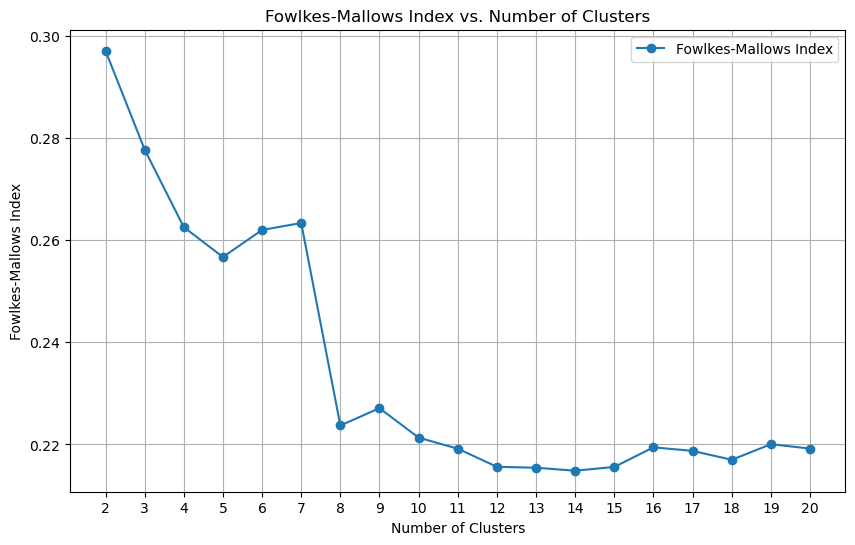

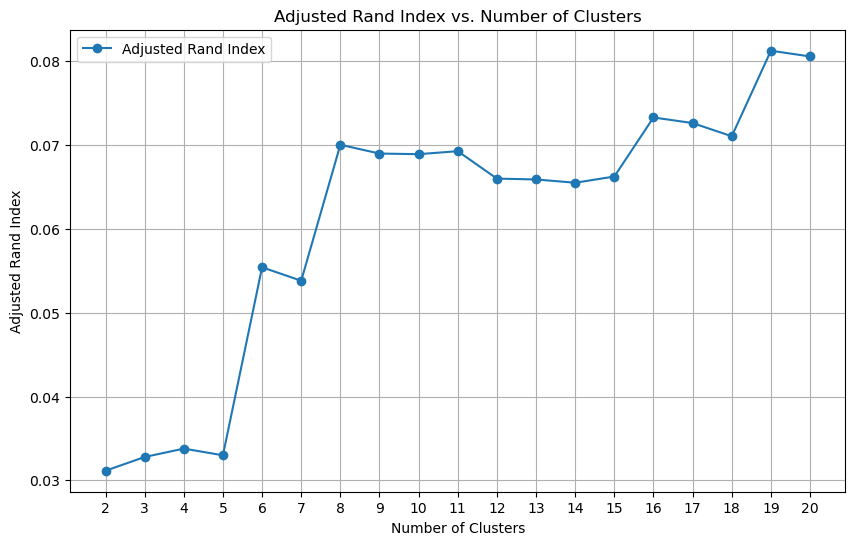

In [19]:
# Plot Homogeneity Score vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, homogeneity_scores, label='Homogeneity Score', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Homogeneity Score')
plt.title('Homogeneity Score vs. Number of Clusters')
plt.xticks(n_clusters_range)
plt.legend()
plt.grid(True)
plt.show()

# Plot Fowlkes-Mallows Index vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, fmi_scores, label='Fowlkes-Mallows Index', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Fowlkes-Mallows Index')
plt.title('Fowlkes-Mallows Index vs. Number of Clusters')
plt.xticks(n_clusters_range)
plt.legend()
plt.grid(True)
plt.show()

# Plot Adjusted Rand Index vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, ari_scores, label='Adjusted Rand Index', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index vs. Number of Clusters')
plt.xticks(n_clusters_range)
plt.legend()
plt.grid(True)
plt.show()

-- INSERT MORE ON DISCUSSION BETWEEN THE THREE METRICS ABOVE --

##### The Homogenity Score and ARI for 9 clusters appears to yield high values relative to those for 7 and blow clusters. While still not ideal, a cluster count of 9 appears to be the best of the poorer options. 

## 6. Comparing ground truth labels to K-means clustering labels

#### Below are plots comparing the ground truth labels from the image data (top) to that of the K-means clustering with a cluster count of 9 (bottom).

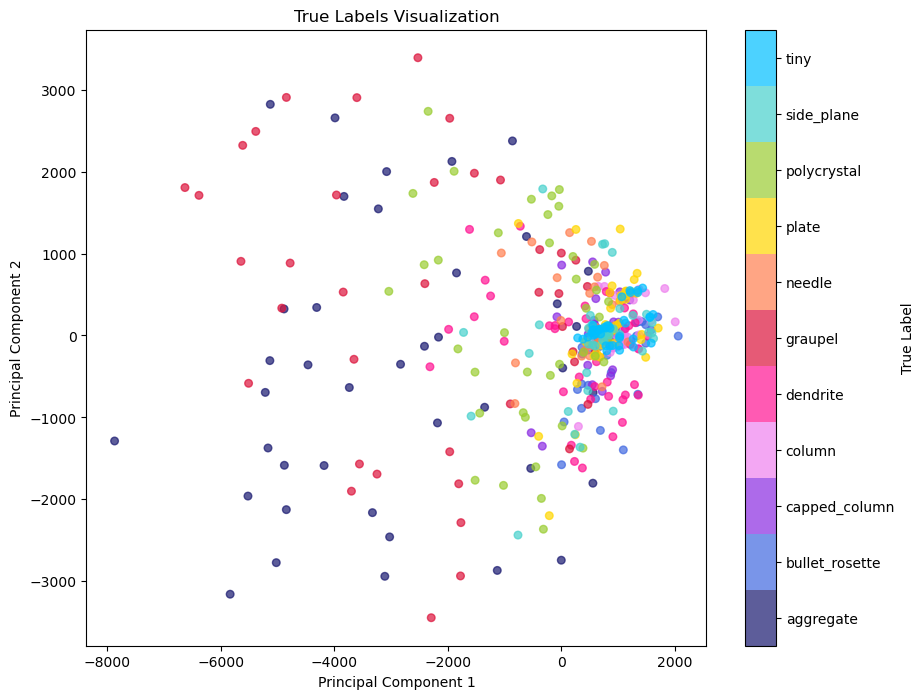

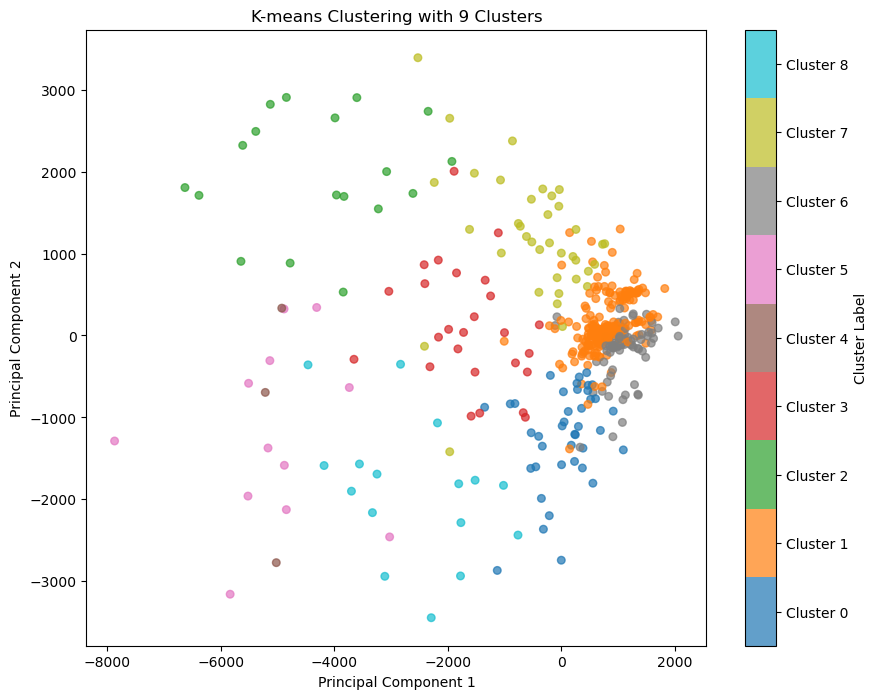

In [29]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define custom colors for the 11 habits
custom_colors = [
    "midnightblue", "royalblue", "blueviolet", "violet",
    "deeppink", "crimson", "coral", "gold",
    "yellowgreen", "mediumturquoise", "deepskyblue"
]

# Create a custom colormap
cmap = ListedColormap(custom_colors)

# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2).fit_transform(pca_result)

# Convert 'true_labels' to NumPy array
true_labels_array = true_labels.values

# Initialize LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels_array)

# Get the number of unique categories
n_categories = len(label_encoder.classes_)

# Define the boundaries and create a norm for true labels
boundaries = np.linspace(-0.5, n_categories - 0.5, n_categories + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the clusters with encoded true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_2d[:, 0], pca_2d[:, 1],
    c=true_labels_encoded,
    cmap=cmap,
    norm=norm,
    s=30,
    alpha=0.7
)
plt.title('True Labels Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a color bar with centered ticks and actual labels
cbar = plt.colorbar(scatter, spacing='uniform', ticks=np.arange(n_categories))
cbar.set_label('True Label')
cbar.set_ticks(np.arange(n_categories))
cbar.set_ticklabels(label_encoder.classes_)

plt.show()

# Plot clustering results for optimal number of clusters
optimal_n_clusters = 9  # Replace with your optimal number
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_result)

# Ensure 'cluster_labels' is a NumPy array
cluster_labels = np.array(cluster_labels)

# Get the number of clusters
n_clusters = optimal_n_clusters

# Create a discrete colormap for clusters
cmap_clusters = plt.cm.get_cmap('tab10', n_clusters)

# Define the boundaries and create a norm for clusters
boundaries_clusters = np.linspace(-0.5, n_clusters - 0.5, n_clusters + 1)
norm_clusters = BoundaryNorm(boundaries_clusters, cmap_clusters.N)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_2d[:, 0], pca_2d[:, 1],
    c=cluster_labels,
    cmap=cmap_clusters,
    norm=norm_clusters,
    s=30,
    alpha=0.7
)
plt.title(f'K-means Clustering with {optimal_n_clusters} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a color bar with centered ticks and cluster labels
cbar = plt.colorbar(scatter, spacing='uniform', ticks=np.arange(n_clusters))
cbar.set_label('Cluster Label')
cbar.set_ticks(np.arange(n_clusters))
cbar.set_ticklabels([f'Cluster {i}' for i in range(n_clusters)])

plt.show()

##### Classes that appear relatively well-represented in the clustering are the tiny category, having similar features to Cluster 1, and partially the aggregate and graupel categories, represented in clusters 5 and 8, respectively. 

-- INSERT MORE COMMENTS IF ANY --

## 7. Testing robustness of 9 clusters using repeated runs with random seeds

In [ ]:
# insert code here

## Takeaways

##### Feature extraction using clustering analysis does not appear to be effective in the image dataset. Despite performing dimension reduction on the data, it does not appear to have a strong clustering structure.

-- INSERT FURTHER DISCUSSION ON HOW CLUSTERING ANALYSIS INFORMS OUR APPROACH TO CLASSIFICATION -- 
